In [1]:
import requests as rq
from datetime import datetime
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from typing import List, Tuple, Iterator
from collections import defaultdict

In [2]:
start_time = "2021-07-22%2000:00:00"
end_time = "2021-07-29%2000:00:00"
token = rq.post(url = f"https://aqrt.nrs.gov.bc.ca/Export/DataSetToken?DataSet=SGWL.Working%40OW283&StartTime={start_time}&EndTime={end_time}&ExportFormat=csv&Compressed=false&RoundData=False&Unit=306&Timezone=-7").json()["Token"]
raw_csv = rq.get(url = f"https://aqrt.nrs.gov.bc.ca/Export/DataSet?DataSet=SGWL.Working%40OW283&StartTime={start_time}&EndTime={end_time}&ExportFormat=csv&Compressed=false&RoundData=False&Unit=306&Timezone=-7&Token={token.replace('+', '%2B').replace('/', r'%2F')}")
reader = list(csv.reader(raw_csv.text.splitlines()))

In [3]:
def clean_and_process(stamp: str, value: str, code: str):
    try:
        if int(code) < 0:
            return False
    except ValueError:
        return False
    if stamp[5:10] == "02-29": # janky hack, mate!
        return False # 😭
    if float(value) > 11:
        return False
    return (
        datetime.fromisoformat(stamp + '-07:00'),
        -float(value)
    )
cleaned = np.transpose(tuple(filter(lambda x: x, map(lambda x: clean_and_process(x[0], x[1], x[3]), reader))))

In [4]:
def year_splitter(days: Iterator[Tuple[datetime, float]]) -> List[List[Tuple[datetime, float]]]:
    years = [[] for _ in range(2021-1983 + 1)]
    for day in days:
        years[day[0].year-1983].append(day)
    return years
    
def unify_year(dates: List[Tuple[datetime, float]]):
    unified_dates = []
    for date in dates:
        unified_dates.append((date[0].replace(year=2021), date[1]))
        # print(date[0].year)
    return unified_dates

with open("data/dataset.csv") as data:
    parsed = filter(lambda x: x, map(lambda x: clean_and_process(x[0], x[1], x[3]), csv.reader(data)))
    split = year_splitter(parsed)
    years = list(map(lambda x: np.transpose(unify_year(x)), split))

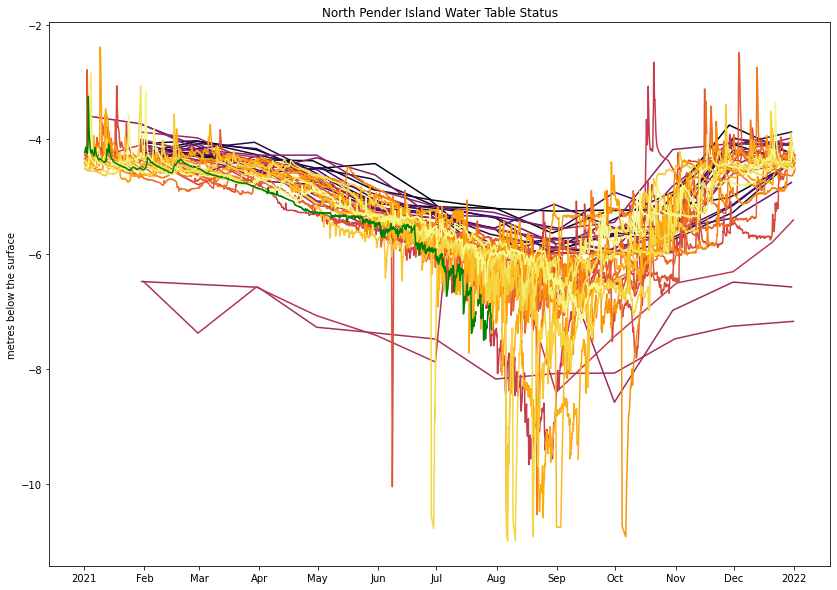

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)

ax.set_ylabel("metres below the surface")
ax.set_title("North Pender Island Water Table Status")

locator = mdates.AutoDateLocator(minticks=3, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

colourmap = cm.get_cmap('inferno')

year_plots = []

for i, year in enumerate(years[:-1]):
    year_as_percentage = i/(2021-1983)
    (year_plot, ) = ax.plot(year[0], year[1], color=colourmap(year_as_percentage))
    year_plot
    year_plots.append(year_plot)
ax.plot(years[-1][0], years[-1][1], color="green")